In [1]:
# import libraries
import os
import json
import nltk
import re
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GRU
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from gensim.test.utils import datapath
from gensim import utils
from nltk.tokenize import word_tokenize
import sqlite3
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import time  # To time our operations
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score, accuracy_score,hamming_loss
import pkg_resources
from symspellpy.symspellpy import SymSpell
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import spacy
from wordcloud import WordCloud

In [2]:
spacy.load('xx_ent_wiki_sm')

In [3]:
spacy.load('en_core_web_sm')

In [4]:
spacy.load("en_core_web_lg")

## Loading dataset

In [5]:
analysis_df = pd.read_json('Analysis_data.json', lines=True)
analysis_df.head()

,category,headline,authors,link,short_description,date
0,POLITICS,The Threat Of A Right-Wing Supreme Court: Anal...,"Marjorie Cohn, ContributorProfessor Emerita at...",https://www.huffingtonpost.com/entry/the-threa...,As the media focuses on Donald Trump’s sexuall...,2016-10-22
1,POLITICS,Hillary Clinton Really Wants You To Think She'...,Zach Carter,https://www.huffingtonpost.com/entry/hillary-c...,She isn't. But Bernie Sanders' campaign just t...,2016-01-05
2,POLITICS,Photo of Barack Obama's Irish Immigrant 3rd Gr...,"Megan Smolenyak, ContributorGenealogy Expert, ...",https://www.huffingtonpost.com/entry/photo-of-...,It was seven years ago when I identified Fulmo...,2014-12-20
3,TRAVEL,My Dog Ate Europe,"Rick Steves, Contributor\nContributor",https://www.huffingtonpost.com/entry/wheres-th...,"Here are some ""interesting"" emails that our he...",2012-02-21
4,POLITICS,Rethinking The Battlefield,"Sen. Chris Murphy, ContributorUnited States Se...",https://www.huffingtonpost.com/entry/rethinkin...,America must have the capacity to truly respon...,2017-04-10


In [6]:
# This is to check if we have Nan values in our data, this shows the number of missing value per each column
np.sum(analysis_df.isnull())

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [7]:
# This is to check the data type of each column in the data
analysis_df.dtypes

category                     object
headline                     object
authors                      object
link                         object
short_description            object
date                 datetime64[ns]
dtype: object

In [8]:
# This is to check if we have missing values in our data, this shows the number of missing value per each column
np.sum(analysis_df == '')

category                0
headline                0
authors              3831
link                    0
short_description    2006
date                    0
dtype: int64

**From the output, we have one missing headline, and there missing information in the authors and short description. Since we are more interested in the headline and category column, we drop the row with missing headline**

In [9]:
# Droping row with missing headline values
analysis_df =analysis_df[analysis_df['headline'] != '']

**Checking for duplicate in the headline column**

In [10]:
analysis_df.shape[0],analysis_df['headline'].nunique()

(25000, 24948)

**Duplicate column has to be drop before training our model**

## Visualization of labels distributions 

**This to have a picture of how the news category are distributed in the dataset**

<AxesSubplot:xlabel='category', ylabel='count'>

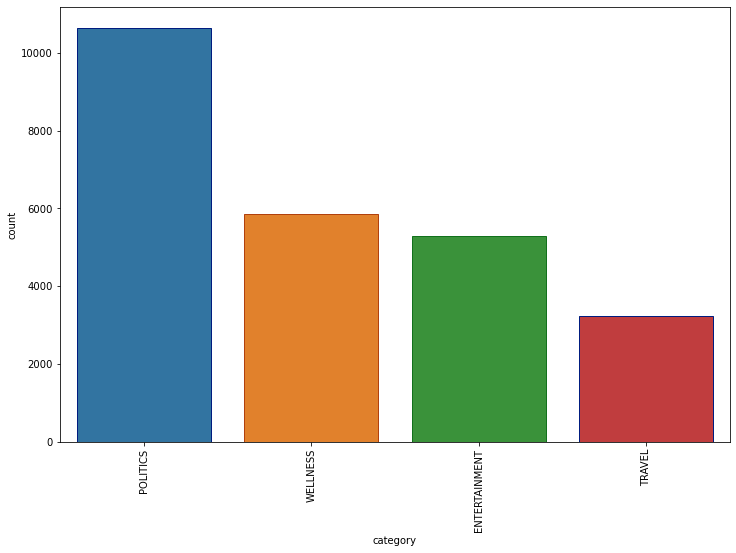

In [11]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
sns.countplot(x='category',data=analysis_df,orient="v",
              edgecolor=sns.color_palette("dark", 3),
              order = analysis_df['category'].value_counts().index)

## Observation 

**From the distribution plot, it can be seen that we have imbalance label in the dataset. This needs to be taking care of when training the model in order to have good model with high accuracy.**

In [12]:
from python_functions import *

## Visualising the top N words inform of world cloud in the dataset 

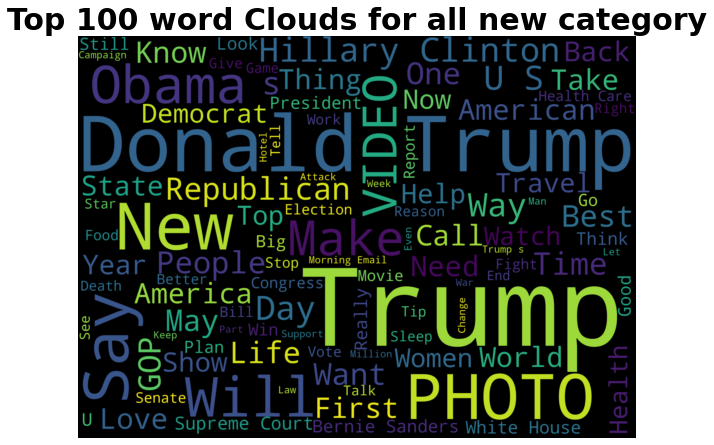

In [13]:
# Create and generate a word cloud image first 100 word of the most common words in the Headline:

text = " ".join(review for review in analysis_df.headline)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100,
                          width=2500,
                          height=1800).generate(text)

# Display the generated image:

plt.figure(figsize=[10,10])
plt.title('Top 100 word Clouds for all new category', size=30, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig("img/por_wine.png", format="png")
plt.show()

In [14]:
## List of all the news categories
columns=analysis_df['category'].unique()
columns

array(['POLITICS', 'TRAVEL', 'WELLNESS', 'ENTERTAINMENT'], dtype=object)

POLITICS


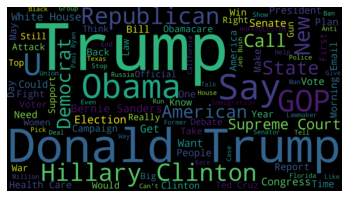

TRAVEL


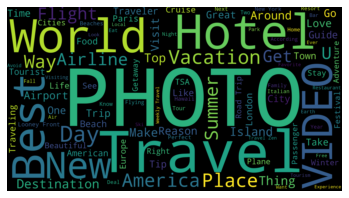

WELLNESS


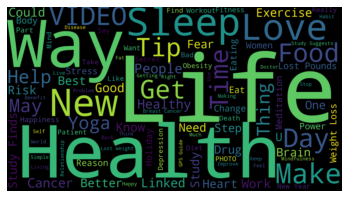

ENTERTAINMENT


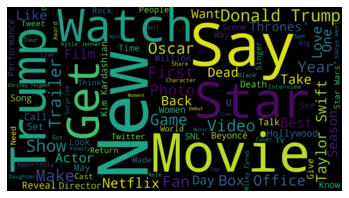

In [16]:
## Ploting word cloud for the first 3 news categories

for cat in columns:
    print(cat)
    plt.imshow(make_word_cloud(analysis_df,'category',cat), interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

## De-noising the dataset and normalisation and Count of each tokens in the dataset

In [17]:
## List of Stopwords in NLTK library
STOPWORDS = stopwords.words('english')
data_set=analysis_df['headline'].tolist()

In [18]:
## De-noising the dataset and normalisation
start = time.time()
clean_da=clean_text_process(data_set,stopwords=STOPWORDS)

print('De-noising the dataset and normalisation completed.: {} mins'.format(round((time.time()-start)/60 , 2)))

De-noising the dataset and normalisation completed.: 0.01 mins


In [19]:
# Count of each tokens in the dataset
start = time.time()
wordcount=word_count(clean_da)
print('Counting of each tokens in the dataset.: {} mins'.format(round((time.time()-start)/60 , 2)))


Counting of each tokens in the dataset.: 0.04 mins


In [20]:
wordcount

,frequency,Unigram
0,3214,trump
1,1117,donald
2,1094,new
3,653,photos
4,609,says
...,...,...
20327,1,abbas
20328,1,abb
20329,1,abandoning
20330,1,ab


<AxesSubplot:title={'center':'Top 10 Word in dataset'}, xlabel='Unigram', ylabel='frequency'>

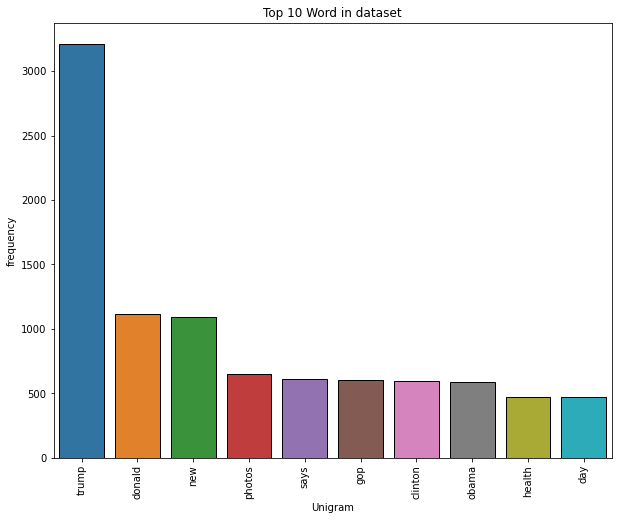

In [21]:
plt.figure(figsize=(10,8))
plt.title('Top 10 Word in dataset')
plt.xticks(rotation=90)
sns.barplot(x=wordcount['Unigram'][0:10],
            y=wordcount['frequency'][0:10]
            ,data=wordcount,edgecolor='black')

**Word count per category**

In [24]:
POLITICS=word_count(clean_text_process(analysis_df[analysis_df['category']=='POLITICS']['headline'].tolist(),
                                       stopwords=STOPWORDS))
TRAVEL=word_count(clean_text_process(analysis_df[analysis_df['category']=='TRAVEL']['headline'].tolist(),
                                       stopwords=STOPWORDS))
ENTERTAINMENT=word_count(clean_text_process(analysis_df[analysis_df['category']=='ENTERTAINMENT']['headline'].tolist(),
                                            stopwords=STOPWORDS))
WELLNESS=word_count(clean_text_process(analysis_df[analysis_df['category']=='WELLNESS']['headline'].tolist(),
                                            stopwords=STOPWORDS))


In [26]:
# Top 20 word
POLITICS[:20]

,frequency,Unigram
0,2969,trump
1,998,donald
2,596,gop
3,565,clinton
4,550,obama
5,419,hillary
6,393,says
7,390,new
8,365,house
9,297,white


In [27]:
# Top 20 word
TRAVEL[:20]

,frequency,Unigram
0,560,photos
1,321,travel
2,205,best
3,193,world
4,164,new
5,122,video
6,102,america
7,94,hotels
8,89,hotel
9,86,day


In [28]:
# Top 20 word
ENTERTAINMENT[:20]

,frequency,Unigram
0,344,new
1,241,trump
2,170,star
3,163,says
4,162,first
5,133,trailer
6,127,video
7,127,movie
8,119,season
9,119,donald


In [29]:
# Top 20 word
WELLNESS[:20]

,frequency,Unigram
0,267,study
1,253,health
2,227,life
3,212,cancer
4,196,new
5,191,sleep
6,187,day
7,167,weight
8,158,could
9,144,ways


## Observation

**Some words occur only 1 time, these words can be remove from our list of word since they will not add to accuracy of the model.** 


## Checking if there are other languages apart from english in the dtataset

In [30]:
from langdetect import detect

# Creating column named language with the type of language the headline is writing
analysis_df['language'] = analysis_df['headline'].apply(detect)

## Visualization of language type distributions 

**This to have a picture of how the news category are distributed interm of language used in the dataset**

<AxesSubplot:xlabel='language', ylabel='count'>

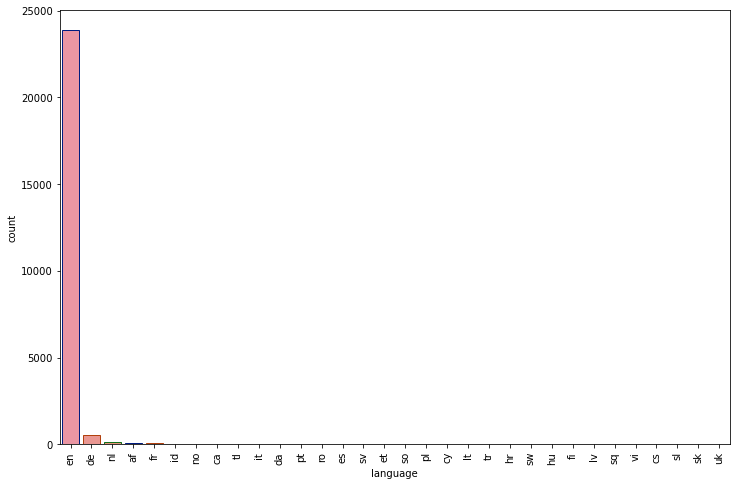

In [31]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
sns.countplot(x='language',data=analysis_df,orient="v",
              edgecolor=sns.color_palette("dark", 3),
              order = analysis_df['language'].value_counts().index)

In [32]:
analysis_df['language'].value_counts()

en    23867
de      518
nl      112
af       73
fr       63
id       53
no       52
ca       42
tl       38
it       27
da       24
pt       22
ro       22
es       19
sv       15
et       14
so        5
pl        5
cy        5
lt        4
tr        4
hr        3
sw        2
hu        2
fi        2
lv        1
sq        1
vi        1
cs        1
sl        1
sk        1
uk        1
Name: language, dtype: int64

## Observation
**We have 31 different languages in the data set, to have a good model we have to drop all the languages except english**

In [36]:
# This count the number of alphabet in each headlines.
analysis_df['headline'].map(lambda x: len(x))

0        80
1        68
2        90
3        17
4        26
         ..
24995    53
24996    68
24997    95
24998    41
24999    71
Name: headline, Length: 25000, dtype: int64